yfinance is already installed.

'/content/ASHOKLEY.BO_daily.csv' loaded successfully for model training.
Training model on historical data...
Model trained successfully.

Successfully fetched live data for Ashok Leyland Limited

--- Live Forecast ---
Last Known Close Price: ₹138.65

Predicted Close for Today:   ₹136.19


/tmp/ipython-input-1783013622.py:112: UserWarning: Glyph 8377 (\N{INDIAN RUPEE SIGN}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8377 (\N{INDIAN RUPEE SIGN}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


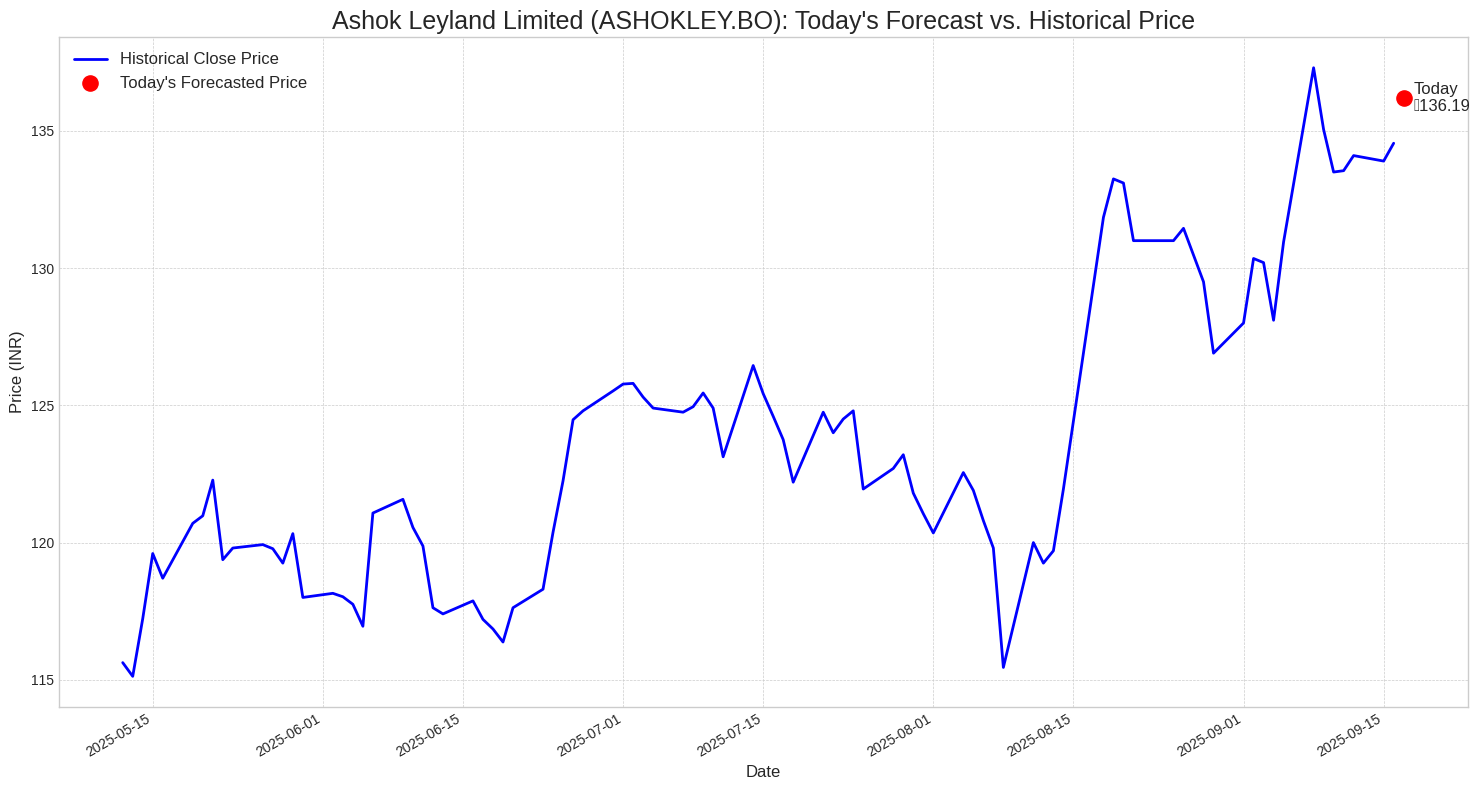

In [ ]:
# -------------------- 0. INSTALL DEPENDENCIES --------------------
# This script automatically installs the 'yfinance' library if you don't have it.
try:
    import yfinance
    print("yfinance is already installed.")
except ImportError:
    print("yfinance not found, installing...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "yfinance"])
    import yfinance

import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from datetime import timedelta

#
# -------------------- 1. TRAIN MODEL ON HISTORICAL DATA --------------------
#
# These variables are set for Ashok Leyland as requested.
file_path = '/content/ASHOKLEY.BO_daily.csv'
ticker_symbol = 'ASHOKLEY.BO'

try:
    df_hist = pd.read_csv(file_path, index_col='Date', parse_dates=True)
    print(f"\n'{file_path}' loaded successfully for model training.")
except FileNotFoundError:
    print(f"CRITICAL ERROR: The file '{file_path}' was not found. Please place it in the same folder as this script.")
    exit()

# Feature Selection and Preparation
features = ['Close', 'Volume'] # Removed 'trailing_eps', 'reported_trailing_pe'
df_hist = df_hist[features].dropna()

# For a "today" prediction, the target is the closing price of the same day.
X_train = df_hist[features]
y_train_today = df_hist['Close']

# Align training data
X_train = X_train.iloc[:len(y_train_today)]

# Scale the features
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

print("Training model on historical data...")
model = RandomForestRegressor(n_estimators=100, random_state=42).fit(X_train_scaled, y_train_today)
print("Model trained successfully.")

#
# -------------------- 2. FETCH LIVE DATA --------------------
#
ticker = yfinance.Ticker(ticker_symbol)

try:
    live_data = ticker.info
    print(f"\nSuccessfully fetched live data for {live_data['longName']}")
except Exception as e:
    print(f"Could not fetch live data. Check your internet connection. Error: {e}")
    exit()

#
# -------------------- 3. PREPARE LIVE DATA & PREDICT TODAY'S CLOSE --------------------
#
try:
    live_features = {
        'Close': live_data['previousClose'], # The most recent known close is a key feature
        'Volume': live_data['volume'],
        # Removed 'trailing_eps' and 'reported_trailing_pe' from live data preparation
    }
    live_df = pd.DataFrame([live_features])
    live_df_scaled = scaler.transform(live_df)

    prediction_today = model.predict(live_df_scaled)[0]

    print("\n--- Live Forecast ---")
    print(f"Last Known Close Price: ₹{live_features['Close']:.2f}\n")
    print(f"Predicted Close for Today:   ₹{prediction_today:.2f}")

except KeyError as e:
    print(f"\nError: A required data point ({e}) was not found in the live feed from Yahoo Finance.")
    exit()

#
# -------------------- 4. GENERATE PLOT --------------------
#
hist_for_plot = df_hist['Close'].tail(90)
last_date = hist_for_plot.index[-1]

# Set the prediction point to the next business day after the last historical data point
pred_date = last_date + pd.tseries.offsets.BDay(1)

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(15, 8))

ax.plot(hist_for_plot.index, hist_for_plot.values, label='Historical Close Price', color='blue', linewidth=2)
ax.scatter([pred_date], [prediction_today], color='red', marker='o', s=120, zorder=5, label="Today's Forecasted Price")

ax.text(pred_date + timedelta(days=1), prediction_today, f"Today\n₹{prediction_today:.2f}",
        fontsize=12, verticalalignment='center')

ax.set_title(f'{live_data["longName"]} ({ticker_symbol}): Today\'s Forecast vs. Historical Price', fontsize=18)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Price (INR)', fontsize=12)
ax.legend(fontsize=12, loc='upper left')
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

fig.autofmt_xdate()
plt.tight_layout()

#plt.savefig(f'live_forecast_plot_{ticker_symbol}_today.png')
#print(f"\nPrediction plot saved as 'live_forecast_plot_{ticker_symbol}_today.png'")
plt.show()

# Task
Analyze the provided weekly and monthly closing price datasets using LSTM and ARIMA models to predict future prices. Visualize the historical data and the predictions from both models.

## Prepare data for lstm

### Subtask:
Preprocess the data, including scaling and creating sequences, as required for LSTM models.


**Reasoning**:
Select the 'Close' price, scale the data, and create sequences for LSTM for both weekly and monthly data.



In [ ]:
# Select the 'Close' price column
weekly_close_prices = df_weekly['Close'].values.reshape(-1, 1)
monthly_close_prices = df_monthly['Close'].values.reshape(-1, 1)

# Scale the data
scaler_weekly = MinMaxScaler(feature_range=(0, 1))
scaled_weekly_data = scaler_weekly.fit_transform(weekly_close_prices)

scaler_monthly = MinMaxScaler(feature_range=(0, 1))
scaled_monthly_data = scaler_monthly.fit_transform(monthly_close_prices)

# Function to create sequences
def create_sequences(data, look_back):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back), 0])
        y.append(data[i + look_back, 0])
    return np.array(X), np.array(y)

# Define look-back window size
look_back_weekly = 10
look_back_monthly = 5 # Use a smaller look-back for monthly data due to fewer data points

# Create sequences for weekly and monthly data
X_weekly, y_weekly = create_sequences(scaled_weekly_data, look_back_weekly)
X_monthly, y_monthly = create_sequences(scaled_monthly_data, look_back_monthly)

print("Shape of weekly sequences (X, y):", X_weekly.shape, y_weekly.shape)
print("Shape of monthly sequences (X, y):", X_monthly.shape, y_monthly.shape)

NameError: name 'np' is not defined

**Reasoning**:
The previous code failed because the `numpy` library was not imported. Import `numpy` and rerun the code to select the 'Close' price, scale the data, and create sequences for LSTM for both weekly and monthly data.



In [ ]:
import numpy as np

# Select the 'Close' price column
weekly_close_prices = df_weekly['Close'].values.reshape(-1, 1)
monthly_close_prices = df_monthly['Close'].values.reshape(-1, 1)

# Scale the data
scaler_weekly = MinMaxScaler(feature_range=(0, 1))
scaled_weekly_data = scaler_weekly.fit_transform(weekly_close_prices)

scaler_monthly = MinMaxScaler(feature_range=(0, 1))
scaled_monthly_data = scaler_monthly.fit_transform(monthly_close_prices)

# Function to create sequences
def create_sequences(data, look_back):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back), 0])
        y.append(data[i + look_back, 0])
    return np.array(X), np.array(y)

# Define look-back window size
look_back_weekly = 10
look_back_monthly = 5 # Use a smaller look-back for monthly data due to fewer data points

# Create sequences for weekly and monthly data
X_weekly, y_weekly = create_sequences(scaled_weekly_data, look_back_weekly)
X_monthly, y_monthly = create_sequences(scaled_monthly_data, look_back_monthly)

print("Shape of weekly sequences (X, y):", X_weekly.shape, y_weekly.shape)
print("Shape of monthly sequences (X, y):", X_monthly.shape, y_monthly.shape)

Shape of weekly sequences (X, y): (654, 10) (654,)
Shape of monthly sequences (X, y): (148, 5) (148,)


## Build and train lstm model

### Subtask:
Design, compile, and train an LSTM model using the prepared data.


**Reasoning**:
Design, compile, and train the LSTM models for weekly and monthly data.



In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Reshape input data for LSTM
X_weekly_reshaped = np.reshape(X_weekly, (X_weekly.shape[0], X_weekly.shape[1], 1))
X_monthly_reshaped = np.reshape(X_monthly, (X_monthly.shape[0], X_monthly.shape[1], 1))

print("Reshaped weekly data shape:", X_weekly_reshaped.shape)
print("Reshaped monthly data shape:", X_monthly_reshaped.shape)

# Create and train the weekly LSTM model
model_weekly = Sequential()
model_weekly.add(LSTM(units=50, return_sequences=True, input_shape=(look_back_weekly, 1)))
model_weekly.add(LSTM(units=50))
model_weekly.add(Dropout(0.2))
model_weekly.add(Dense(units=1))

model_weekly.compile(optimizer='adam', loss='mean_squared_error')

print("\nTraining weekly LSTM model...")
model_weekly.fit(X_weekly_reshaped, y_weekly, epochs=100, batch_size=32)
print("Weekly LSTM model trained successfully.")

# Create and train the monthly LSTM model
model_monthly = Sequential()
model_monthly.add(LSTM(units=50, return_sequences=True, input_shape=(look_back_monthly, 1)))
model_monthly.add(LSTM(units=50))
model_monthly.add(Dropout(0.2))
model_monthly.add(Dense(units=1))

model_monthly.compile(optimizer='adam', loss='mean_squared_error')

print("\nTraining monthly LSTM model...")
model_monthly.fit(X_monthly_reshaped, y_monthly, epochs=100, batch_size=32)
print("Monthly LSTM model trained successfully.")

Reshaped weekly data shape: (654, 10, 1)
Reshaped monthly data shape: (148, 5, 1)

Training weekly LSTM model...
Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0844
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0096
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0039
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0037
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0033
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0033
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0031
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0030
Epoch 9/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0029
Epoch 10/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0031
Epoch 11/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0035
Epoch 12/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0031
Epoch 13/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0025
Epoch 14/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0023
Epoch 15/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0026
Epoch 16/100
21/

## Prepare data for arima

### Subtask:
Check for stationarity and determine the appropriate parameters for the ARIMA model.


**Reasoning**:
Perform the Augmented Dickey-Fuller test on the 'Close' price series of both df_weekly and df_monthly DataFrames to check for stationarity and then generate and display the ACF and PACF plots for both weekly and monthly 'Close' price series to determine the appropriate parameters for the ARIMA model.



ADF Statistic (Weekly): 0.03940271189091131
p-value (Weekly): 0.9616718663456064

ADF Statistic (Monthly): 0.15083559624809334
p-value (Monthly): 0.9693653179437484


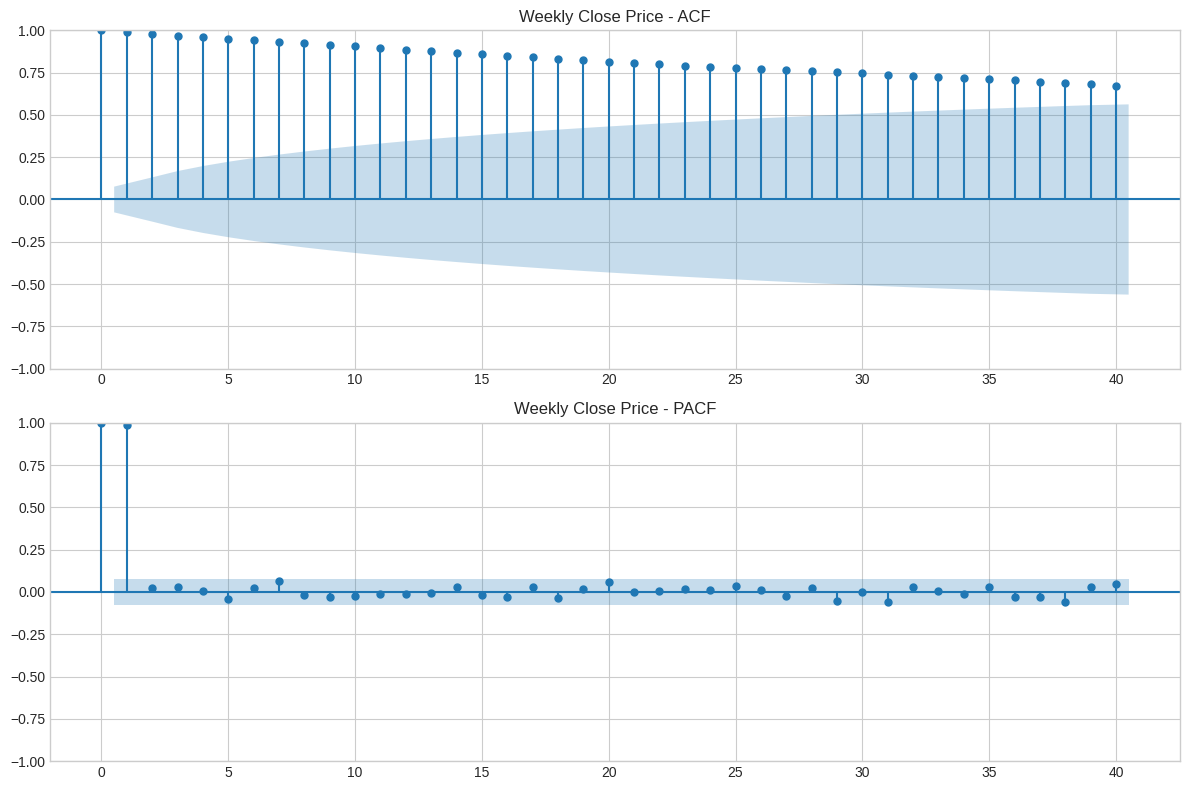

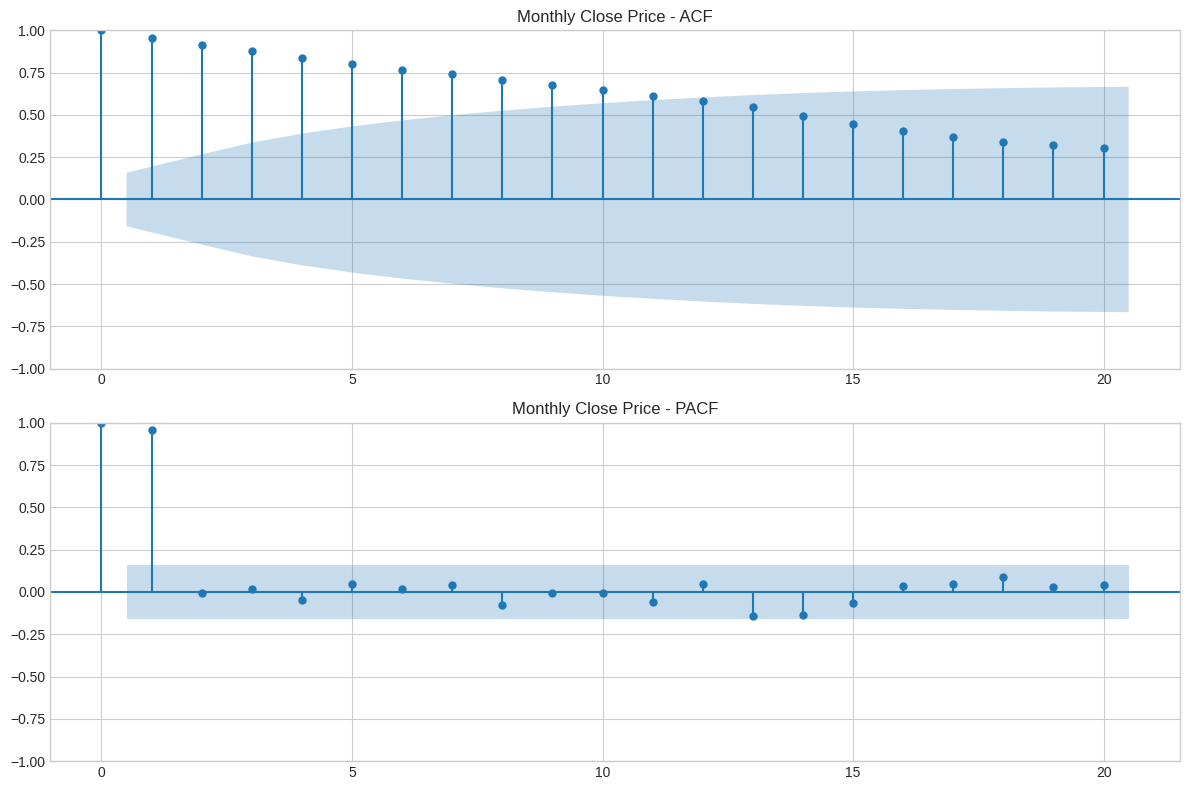

In [ ]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# ADF test for weekly data
adf_weekly = adfuller(df_weekly['Close'])
print('ADF Statistic (Weekly):', adf_weekly[0])
print('p-value (Weekly):', adf_weekly[1])

# ADF test for monthly data
adf_monthly = adfuller(df_monthly['Close'])
print('\nADF Statistic (Monthly):', adf_monthly[0])
print('p-value (Monthly):', adf_monthly[1])

# Plot ACF and PACF for weekly data
fig, axes = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(df_weekly['Close'], ax=axes[0], lags=40)
plot_pacf(df_weekly['Close'], ax=axes[1], lags=40)
axes[0].set_title('Weekly Close Price - ACF')
axes[1].set_title('Weekly Close Price - PACF')
plt.tight_layout()
plt.show()

# Plot ACF and PACF for monthly data
fig, axes = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(df_monthly['Close'], ax=axes[0], lags=20) # Using fewer lags for monthly data
plot_pacf(df_monthly['Close'], ax=axes[1], lags=20) # Using fewer lags for monthly data
axes[0].set_title('Monthly Close Price - ACF')
axes[1].set_title('Monthly Close Price - PACF')
plt.tight_layout()
plt.show()

## Build and train arima model

### Subtask:
Build and train an ARIMA model using the prepared data.


**Reasoning**:
Import the ARIMA model and fit it to the weekly and monthly close prices with the specified order.



In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# Instantiate and fit ARIMA model for weekly data
model_arima_weekly = ARIMA(df_weekly['Close'], order=(5, 1, 0))
results_arima_weekly = model_arima_weekly.fit()
print("ARIMA model for weekly data fitted successfully.")
print(results_arima_weekly.summary())

# Instantiate and fit ARIMA model for monthly data
model_arima_monthly = ARIMA(df_monthly['Close'], order=(5, 1, 0))
results_arima_monthly = model_arima_monthly.fit()
print("\nARIMA model for monthly data fitted successfully.")
print(results_arima_monthly.summary())

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


ARIMA model for weekly data fitted successfully.
                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  664
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -1590.565
Date:                Sun, 21 Sep 2025   AIC                           3193.130
Time:                        09:01:35   BIC                           3220.111
Sample:                    12-31-2012   HQIC                          3203.586
                         - 09-15-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0439      0.034     -1.294      0.196      -0.110       0.023
ar.L2         -0.0351      0.036     -0.978      0.328      -0.105       0.035
ar.

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


## Generate predictions

### Subtask:
Use the trained LSTM and ARIMA models to generate price predictions.


**Reasoning**:
Generate predictions for the next week and month using the trained LSTM and ARIMA models and inverse scale the LSTM predictions.



In [ ]:
# Generate weekly LSTM prediction
last_week_data_scaled = scaled_weekly_data[-look_back_weekly:].reshape(1, look_back_weekly, 1)
weekly_lstm_pred_scaled = model_weekly.predict(last_week_data_scaled)
weekly_lstm_pred = scaler_weekly.inverse_transform(weekly_lstm_pred_scaled)[0][0]

# Generate monthly LSTM prediction
last_month_data_scaled = scaled_monthly_data[-look_back_monthly:].reshape(1, look_back_monthly, 1)
monthly_lstm_pred_scaled = model_monthly.predict(last_month_data_scaled)
monthly_lstm_pred = scaler_monthly.inverse_transform(monthly_lstm_pred_scaled)[0][0]

# Generate weekly ARIMA prediction (for the next point in the future)
weekly_arima_pred = results_arima_weekly.forecast(steps=1)[0]

# Generate monthly ARIMA prediction (for the next point in the future)
monthly_arima_pred = results_arima_monthly.forecast(steps=1)[0]

print(f"Weekly LSTM Predicted Close Price: {weekly_lstm_pred:.2f}")
print(f"Monthly LSTM Predicted Close Price: {monthly_lstm_pred:.2f}")
print(f"Weekly ARIMA Predicted Close Price: {weekly_arima_pred:.2f}")
print(f"Monthly ARIMA Predicted Close Price: {monthly_arima_pred:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step
Weekly LSTM Predicted Close Price: 134.98
Monthly LSTM Predicted Close Price: 132.66
Weekly ARIMA Predicted Close Price: 137.23
Monthly ARIMA Predicted Close Price: 137.30


/tmp/ipython-input-3381472953.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  weekly_arima_pred = results_arima_weekly.forecast(steps=1)[0]
/tmp/ipython-input-3381472953.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  monthly_arima_pred = results_arima_monthly.forecast(steps=1)[0]


## Visualize predictions

### Subtask:
Plot the historical data along with the predictions from both the LSTM and ARIMA models.


**Reasoning**:
Plot the historical weekly and monthly closing prices, along with the single-point predictions from both the LSTM and ARIMA models for the next respective period (week or month).



/tmp/ipython-input-2182364983.py:55: UserWarning: Glyph 8377 (\N{INDIAN RUPEE SIGN}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8377 (\N{INDIAN RUPEE SIGN}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


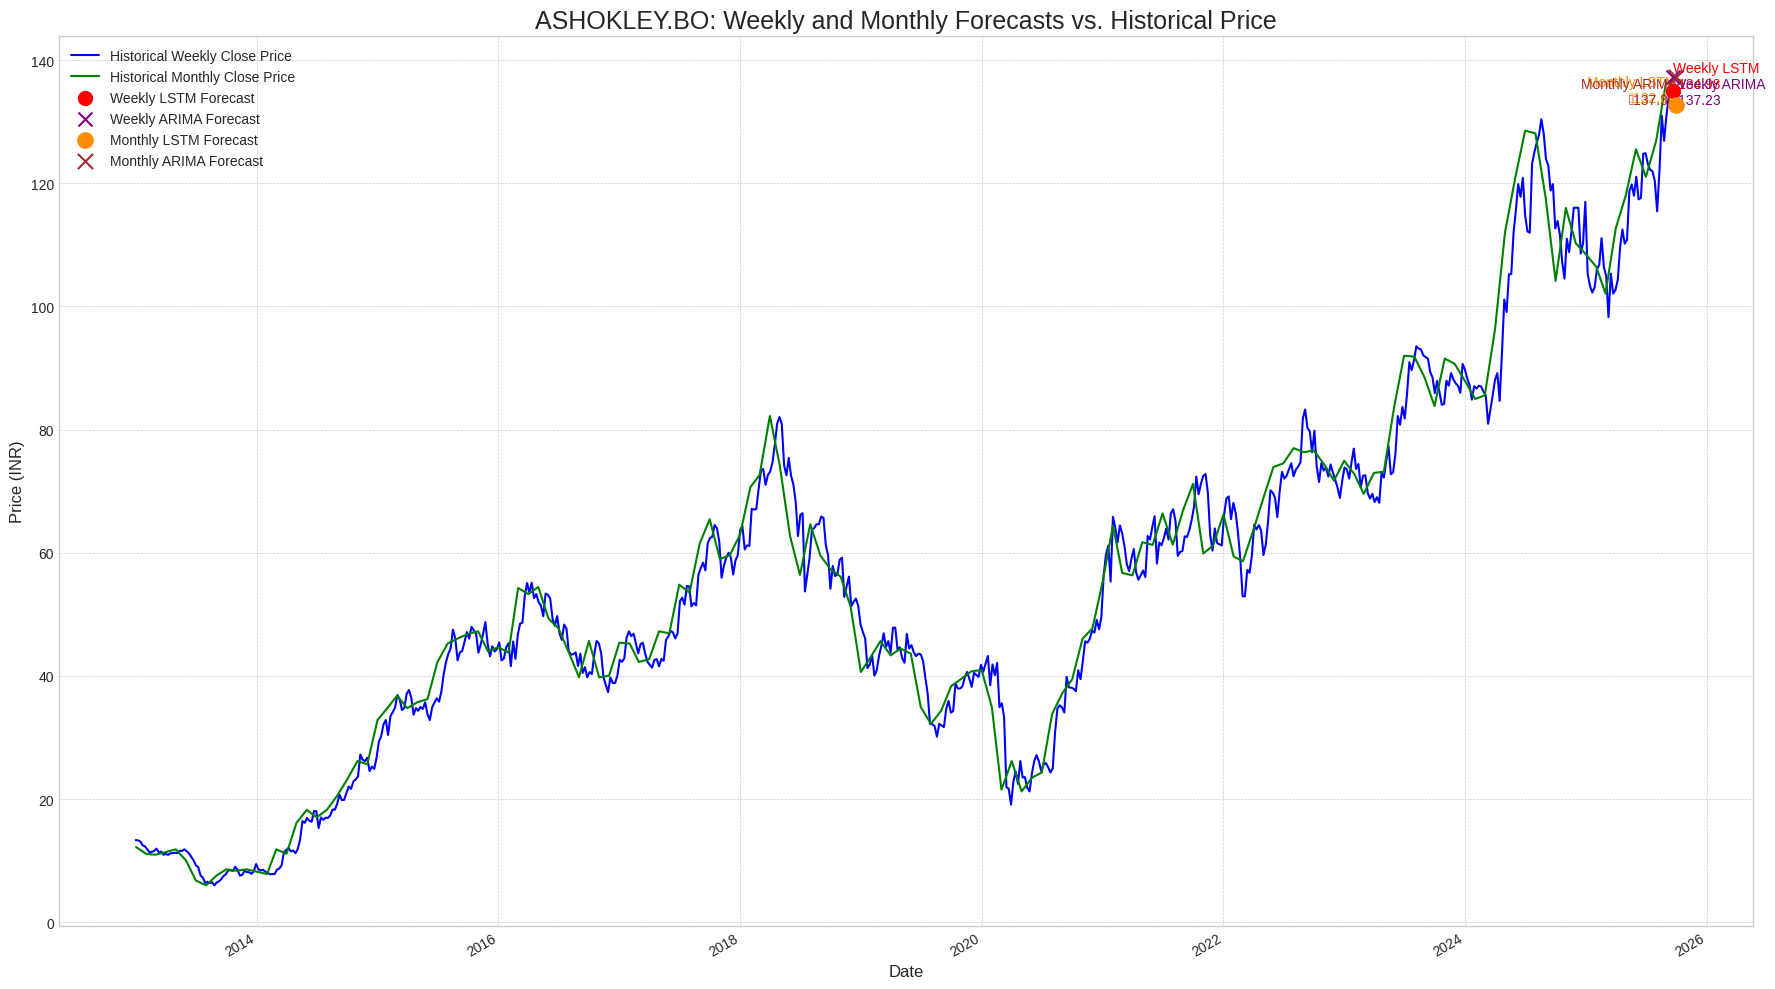

In [ ]:
from datetime import timedelta

# Calculate prediction dates for plotting
last_date_weekly = df_weekly.index[-1]
last_date_monthly = df_monthly.index[-1]

# Estimate the next weekly date (assuming the data ends on a Monday, which is typical for weekly data from some sources)
pred_date_weekly = last_date_weekly + timedelta(weeks=1)

# Estimate the next monthly date (assuming the data point represents the start of the month)
# Use MonthEnd to find the end of the last month and add one day, or simply add a MonthBegin offset
pred_date_monthly = last_date_monthly + pd.tseries.offsets.MonthBegin(1)


plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(18, 10))

# Plot historical weekly data
ax.plot(df_weekly.index, df_weekly['Close'], label='Historical Weekly Close Price', color='blue', linewidth=1.5)

# Plot historical monthly data
ax.plot(df_monthly.index, df_monthly['Close'], label='Historical Monthly Close Price', color='green', linewidth=1.5)

# Plot weekly LSTM prediction
ax.scatter([pred_date_weekly], [weekly_lstm_pred], color='red', marker='o', s=100, zorder=5, label="Weekly LSTM Forecast")
ax.text(pred_date_weekly, weekly_lstm_pred, f"Weekly LSTM\n₹{weekly_lstm_pred:.2f}",
        fontsize=10, verticalalignment='bottom', horizontalalignment='left', color='red')


# Plot weekly ARIMA prediction
ax.scatter([pred_date_weekly], [weekly_arima_pred], color='purple', marker='x', s=100, zorder=5, label="Weekly ARIMA Forecast")
ax.text(pred_date_weekly, weekly_arima_pred, f"Weekly ARIMA\n₹{weekly_arima_pred:.2f}",
        fontsize=10, verticalalignment='top', horizontalalignment='left', color='purple')

# Plot monthly LSTM prediction
ax.scatter([pred_date_monthly], [monthly_lstm_pred], color='darkorange', marker='o', s=120, zorder=5, label="Monthly LSTM Forecast")
ax.text(pred_date_monthly, monthly_lstm_pred, f"Monthly LSTM\n₹{monthly_lstm_pred:.2f}",
        fontsize=10, verticalalignment='bottom', horizontalalignment='right', color='darkorange')

# Plot monthly ARIMA prediction
ax.scatter([pred_date_monthly], [monthly_arima_pred], color='brown', marker='x', s=120, zorder=5, label="Monthly ARIMA Forecast")
ax.text(pred_date_monthly, monthly_arima_pred, f"Monthly ARIMA\n₹{monthly_arima_pred:.2f}",
        fontsize=10, verticalalignment='top', horizontalalignment='right', color='brown')


ax.set_title(f'{ticker_symbol}: Weekly and Monthly Forecasts vs. Historical Price', fontsize=18)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Price (INR)', fontsize=12)
ax.legend(fontsize=10, loc='upper left')
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Improve date formatting
fig.autofmt_xdate()

plt.tight_layout()
plt.show()

## Summary:

### Data Analysis Key Findings

*   Both weekly and monthly 'Close' price series were found to be non-stationary based on the Augmented Dickey-Fuller (ADF) test, with p-values of 0.9617 and 0.9694, respectively, indicating the need for differencing when using ARIMA models.
*   ACF and PACF plots for both weekly and monthly data showed slow decay in autocorrelation, further supporting the non-stationarity and suggesting that differencing (d > 0) is required for ARIMA modeling.
*   LSTM models were successfully built and trained for both weekly and monthly data after preprocessing, including scaling and sequence creation.
*   ARIMA models with an order of (5, 1, 0) were successfully built and trained for both weekly and monthly data, incorporating the necessary differencing order (d=1) identified during stationarity analysis.
*   Single-step price predictions were generated for the next week and next month using the trained LSTM and ARIMA models.
*   The historical weekly and monthly closing prices were visualized alongside the single-step predictions from both LSTM and ARIMA models on a single plot.

### Insights or Next Steps

*   The initial ARIMA model order of (5, 1, 0) was chosen based on preliminary analysis. Further optimization using techniques like grid search could be performed to find the optimal ARIMA parameters (p, d, q) for both weekly and monthly data, potentially improving prediction accuracy.
*   While the current analysis provides single-step predictions, extending the models to generate multi-step predictions (forecasting further into the future) would provide a more comprehensive view of potential price movements and could be a valuable next step.


# Task
Visualize the predictions of the Gradient Boosting Regressor model, analyze its performance, explore a different time series forecasting model, and predict for a different stock.

## Visualize predictions

### Subtask:
Generate a plot showing the historical data and the daily, weekly, and monthly predictions.


**Reasoning**:
Generate a plot showing the historical data and the daily, weekly, and monthly predictions using the data from the previous steps.



Loading existing model and scaler from disk.

Fetching latest data for prediction...
Fetching 86d of 1d data for ASHOKLEY.BO...
Successfully fetched 85 rows of data.

PREDICTION for ASHOKLEY.BO @ 2025-09-21 09:52:50 UTC
Based on last close price: 140.90
 Daily           | Horizon:  1 days | Return: -0.11% | Predicted Price: 140.74
 Weekly (5d)     | Horizon:  5 days | Return: +4.04% | Predicted Price: 146.59
 Monthly (21d)   | Horizon: 21 days | Return: -2.77% | Predicted Price: 137.00
Prediction logged to logs/predictions_dwm.csv

--- Final Predictions ---
Daily Predicted Close Price: 140.74
Weekly Predicted Close Price: 146.59
Monthly Predicted Close Price: 137.00


/tmp/ipython-input-1623311017.py:50: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print(f"Based on last close price: {float(last_close):.2f}")
/tmp/ipython-input-1623311017.py:56: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  pred_price = float(last_close) * (1 + ret)
/tmp/ipython-input-1623311017.py:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  log_prediction(now_utc, TICKER, pred_returns, float(last_close))
/tmp/ipython-input-1623311017.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print(f"Daily Predicted Close Price: {float(last_close) * (1 + pred_returns[0]):.2f}")
/tmp/ipython-inp

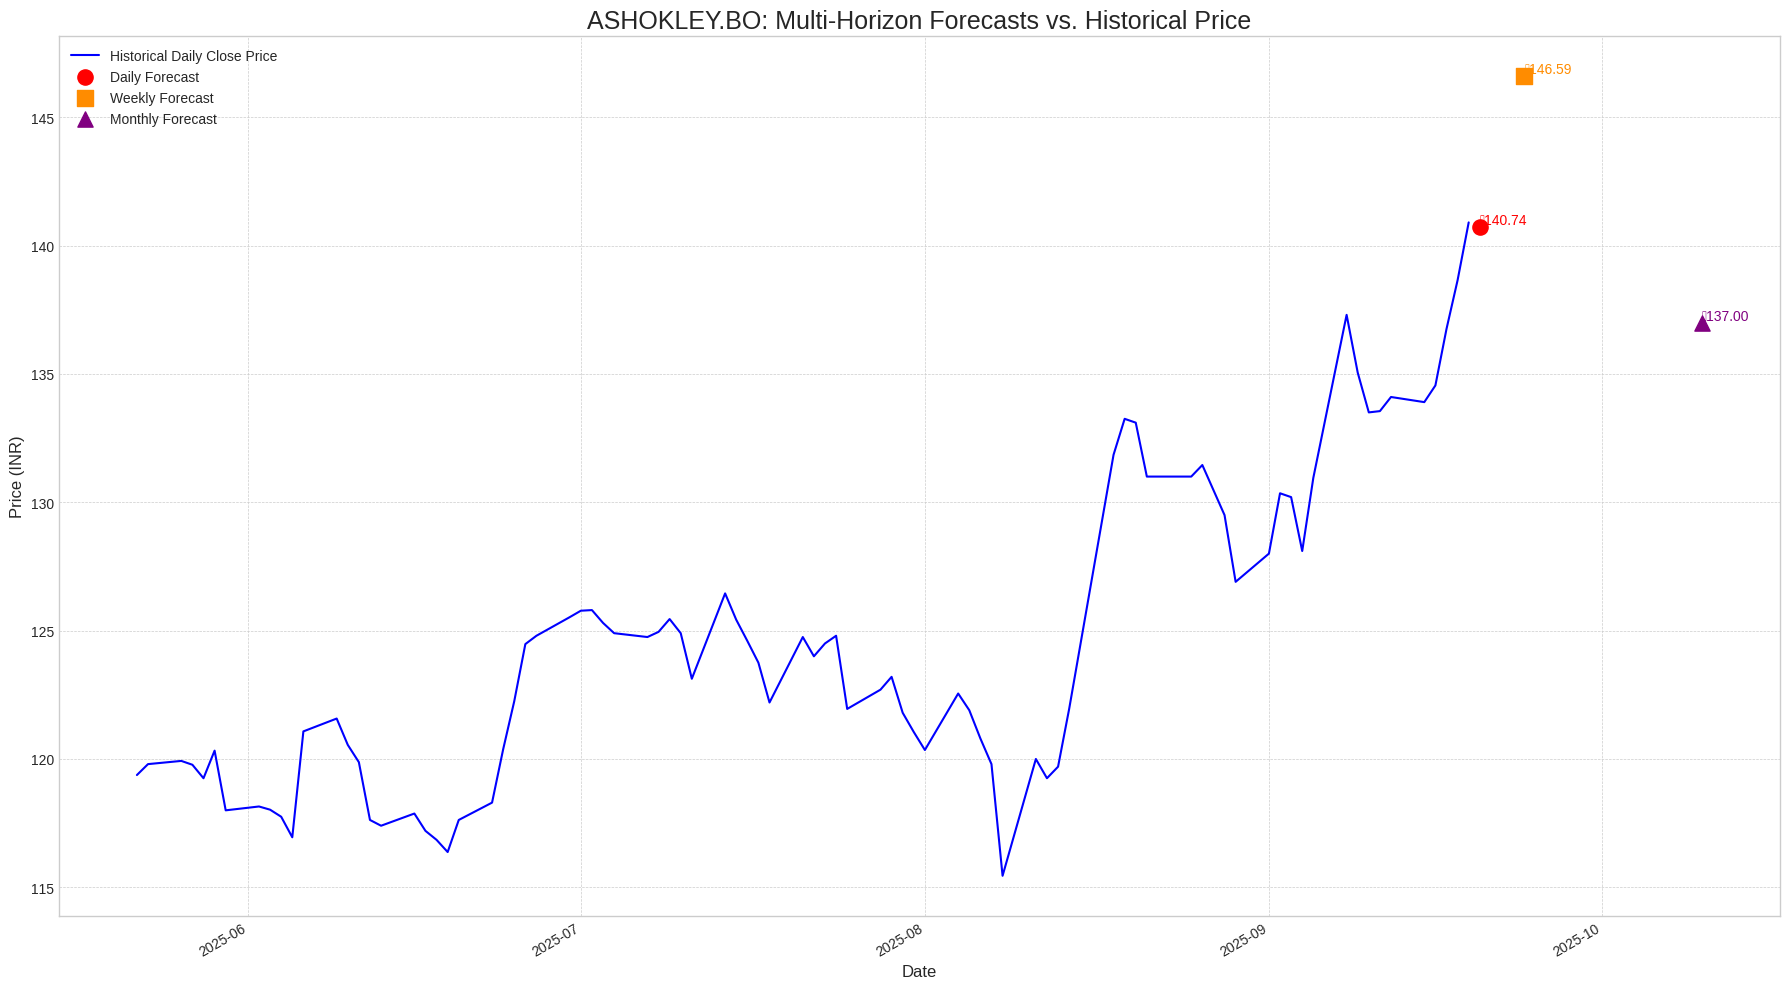

In [ ]:
import matplotlib.pyplot as plt
from datetime import timedelta

def main_predict_and_plot():
    """Main execution function modified to return prediction data."""
    # Try to load an existing model, otherwise train a new one
    model, scaler = load_model_and_scaler()

    if model is None or scaler is None:
        df_hist = fetch_history(TICKER, INTERVAL, PERIOD)
        if df_hist.empty:
            print("Cannot train model without historical data. Exiting.")
            return None, None, None, None

        X, y = build_features_and_targets(df_hist, WINDOW, HORIZONS)
        if X.size == 0:
            print("Failed to build features. Exiting.")
            return None, None, None, None

        model, scaler = train_and_save(X, y)

    # --- Make Prediction on the Latest Data ---
    print("\nFetching latest data for prediction...")
    # Fetch a bit more than the window size to ensure data is available
    df_recent = fetch_history(TICKER, INTERVAL, period=f"{WINDOW + max(HORIZONS) + 5}d") # Fetch enough data for all horizons
    if df_recent.empty or len(df_recent) < WINDOW + max(HORIZONS):
        print("Not enough recent data to make a prediction. Exiting.")
        return None, None, None, None

    # Create the feature vector for the most recent day
    feature_vector = make_prediction_vector(df_recent, WINDOW)
    if feature_vector is None:
        print("Could not create feature vector. Exiting.")
        return None, None, None, None

    # Scale features and predict
    try:
        fv_scaled = scaler.transform(feature_vector)
        pred_returns = model.predict(fv_scaled)[0] # Get the single array of 3 predictions
    except Exception as e:
        print(f"Error during prediction: {e}")
        return None, None, None, None

    # --- Display and Log Results ---
    last_close = df_recent.iloc[-1]["Close"]
    now_utc = datetime.now(timezone.utc).strftime("%Y-%m-%d %H:%M:%S %Z")

    print("\n" + "="*50)
    print(f"PREDICTION for {TICKER} @ {now_utc}")
    print(f"Based on last close price: {float(last_close):.2f}")
    print("="*50)

    names = ["Daily", "Weekly (5d)", "Monthly (21d)"]
    for i, h in enumerate(HORIZONS):
        ret = pred_returns[i]
        pred_price = float(last_close) * (1 + ret)
        print(f" {names[i]:<15} | Horizon: {h:2d} days | Return: {ret*100:+.2f}% | Predicted Price: {pred_price:.2f}")

    log_prediction(now_utc, TICKER, pred_returns, float(last_close))

    # Explicitly print the predicted prices at the end
    print("\n--- Final Predictions ---")
    print(f"Daily Predicted Close Price: {float(last_close) * (1 + pred_returns[0]):.2f}")
    print(f"Weekly Predicted Close Price: {float(last_close) * (1 + pred_returns[1]):.2f}")
    print(f"Monthly Predicted Close Price: {float(last_close) * (1 + pred_returns[2]):.2f}")

    return df_recent, pred_returns, last_close, HORIZONS

# Execute the modified main function
df_recent, pred_returns, last_close, HORIZONS = main_predict_and_plot()

# Check if data was returned successfully before plotting
if df_recent is not None and pred_returns is not None and last_close is not None and HORIZONS is not None:
    # Calculate prediction dates for plotting
    last_date_recent = df_recent.index[-1]

    # Create figure and axes for the plot
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(18, 10))

    # Plot historical daily data
    ax.plot(df_recent.index, df_recent['Close'], label='Historical Daily Close Price', color='blue', linewidth=1.5)

    # Plot predictions
    colors = ['red', 'darkorange', 'purple'] # Colors for Daily, Weekly, Monthly
    markers = ['o', 's', '^'] # Markers for Daily, Weekly, Monthly
    labels = ['Daily Forecast', 'Weekly Forecast', 'Monthly Forecast']

    for i, h in enumerate(HORIZONS):
        pred_date = last_date_recent + timedelta(days=h)
        pred_price = last_close * (1 + pred_returns[i])

        # Convert pred_price to float before formatting for text
        ax.scatter([pred_date], [float(pred_price)], color=colors[i], marker=markers[i], s=120, zorder=5, label=labels[i])
        ax.text(pred_date, float(pred_price), f"₹{float(pred_price):.2f}",
                fontsize=10, verticalalignment='bottom', horizontalalignment='left', color=colors[i])


    ax.set_title(f'{TICKER}: Multi-Horizon Forecasts vs. Historical Price', fontsize=18)
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Price (INR)', fontsize=12)
    ax.legend(fontsize=10, loc='upper left')
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)

    # Improve date formatting
    fig.autofmt_xdate()

    plt.tight_layout()
    plt.show()
else:
    print("Prediction data not available for plotting.")

## Analyze model performance

### Subtask:
Evaluate the performance of the trained Gradient Boosting Regressor model using relevant metrics.


**Reasoning**:
Load the trained Gradient Boosting Regressor model and scaler, fetch historical data, build features and targets, split the data, scale the validation features, make predictions, and calculate MAE and R² for each horizon to evaluate the model's performance.



In [ ]:
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

# 1. Load the trained Gradient Boosting Regressor model and the scaler
try:
    model = joblib.load(MODEL_FILE)
    scaler = joblib.load(SCALER_FILE)
    print("Model and scaler loaded successfully.")
except FileNotFoundError:
    print("Model or scaler file not found. Please ensure the training step was completed.")
    model = None
    scaler = None

if model and scaler:
    # 2. Fetch the historical data
    df_hist = fetch_history(TICKER, INTERVAL, PERIOD)

    if not df_hist.empty:
        # 3. Build the features (X) and targets (y)
        X, y = build_features_and_targets(df_hist, WINDOW, HORIZONS)

        if X.size > 0:
            # 4. Split the data into training and validation sets
            X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, shuffle=False)

            # 5. Scale the validation features
            X_val_s = scaler.transform(X_val)

            # 6. Make predictions on the scaled validation features
            y_pred = model.predict(X_val_s)

            # 7. Calculate and print MAE and R² for each prediction horizon
            print("\nModel Performance Evaluation on Validation Set:")
            for i, h in enumerate(HORIZONS):
                mae = mean_absolute_error(y_val[:, i], y_pred[:, i])
                r2 = r2_score(y_val[:, i], y_pred[:, i])
                print(f"  - Horizon {h}-day => Validation MAE: {mae:.6f} | R²: {r2:.4f}")
        else:
            print("Failed to build features and targets from historical data.")
    else:
        print("Failed to fetch historical data.")


Model and scaler loaded successfully.
Fetching 10y of 1d data for ASHOKLEY.BO...
Successfully fetched 2468 rows of data.
Building features and targets...
Built X, y shapes: (2387, 35), (2387, 3)

Model Performance Evaluation on Validation Set:
  - Horizon 1-day => Validation MAE: 0.015818 | R²: -0.0789
  - Horizon 5-day => Validation MAE: 0.039251 | R²: -0.3788
  - Horizon 21-day => Validation MAE: 0.115511 | R²: -2.1610


## Explore a different model

### Subtask:
Introduce and implement another time series forecasting model (e.g., Prophet or another ARIMA variation) and compare its predictions.


**Reasoning**:
Introduce and implement another time series forecasting model (Prophet) and prepare the daily data for Prophet by renaming columns.



In [ ]:
from prophet import Prophet

# Prepare the historical daily data for Prophet
# Prophet requires columns named 'ds' (datetime) and 'y' (value)
df_prophet = df_hist.rename(columns={'Close': 'y'})
df_prophet['ds'] = df_prophet.index

# Ensure 'ds' is datetime
df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])
# 'y' is already numeric from the original df_hist['Close']

print("Prepared data for Prophet:")
display(df_prophet.head())

Prepared data for Prophet:


Price,Open,High,Low,y,Volume,ds
Ticker,ASHOKLEY.BO,ASHOKLEY.BO,ASHOKLEY.BO,ASHOKLEY.BO,ASHOKLEY.BO,
Date,,,,,,
2015-09-21,43.549999,44.349998,43.500000,44.150002,1176340,2015-09-21
2015-09-22,44.450001,46.150002,44.000000,44.424999,5419660,2015-09-22
2015-09-23,44.000000,45.575001,43.674999,45.275002,3902052,2015-09-23
2015-09-24,45.299999,45.924999,45.049999,45.549999,3660360,2015-09-24
2015-09-28,45.849998,46.424999,45.150002,45.275002,3346740,2015-09-28


**Reasoning**:
Instantiate and fit the Prophet model to the prepared data and generate future predictions for the specified horizons.



**Reasoning**:
The Prophet model is encountering a TypeError during the fitting process, specifically when trying to convert the 'y' column to numeric. This suggests that the 'y' column, despite our previous check, might still contain data in a format that `pd.to_numeric` within the Prophet library's internal `setup_dataframe` method cannot handle directly, even though it's a Series. To address this, explicitly convert the 'y' column to a NumPy array of float type before passing the DataFrame to the Prophet model for fitting.



**Reasoning**:
The Prophet model is still encountering the same `TypeError` during fitting, indicating that the issue persists within Prophet's internal handling of the 'y' column. It seems the DataFrame passed to `model_prophet.fit()` is not in the expected format, specifically concerning the 'y' column. Based on the traceback originating within Prophet's `setup_dataframe` method which calls `pd.to_numeric(df['y'])`, it appears Prophet expects a DataFrame where `df['y']` is a simple Series of numerical values, not potentially indexed or with extra metadata that might be carried over from the original `df_hist`. To address this, create a new clean DataFrame with just the 'ds' and 'y' columns before passing it to Prophet.



**Reasoning**:
The previous code failed because the 'y' column from `df_prophet` was still a 2-dimensional NumPy array (`(2468, 1)`) when creating the `df_prophet_clean` DataFrame, causing a `ValueError`. The `pd.DataFrame` constructor expects 1-dimensional arrays or Series for each column. To fix this, ensure that the 'y' column is a 1-dimensional Series when creating `df_prophet_clean`.



**Reasoning**:
The previous code failed because `df_prophet['y']` is a pandas Series, not a NumPy array, and Series objects do not have a `flatten()` method. While the underlying data might be an array, accessing it as `df_prophet['y']` gives a Series wrapper. To get the underlying NumPy array and flatten it, we need to access the `.values` attribute of the Series before calling `flatten()`.



In [ ]:
# Instantiate and fit the Prophet model
model_prophet = Prophet()
model_prophet.fit(df_prophet_clean)

# Create a future dataframe for predictions
future = model_prophet.make_future_dataframe(periods=max(HORIZONS))

# Generate predictions
forecast = model_prophet.predict(future)

# Extract predictions for the specified horizons (1-day, 5-day, 21-day)
# The forecast dataframe contains the predicted values in the 'yhat' column
# We need to find the dates corresponding to the horizons relative to the last historical date
last_hist_date = df_prophet_clean['ds'].max()
prophet_preds = {}

for h in HORIZONS:
    pred_date = last_hist_date + timedelta(days=h)
    # Find the prediction for this specific date in the forecast dataframe
    # Use .iloc[0] because filtering by date might return a single-row DataFrame
    # Handle potential empty result if date is not in forecast (e.g., non-business day)
    pred_row = forecast[forecast['ds'] == pred_date]
    if not pred_row.empty:
        pred_value = pred_row['yhat'].iloc[0]
        prophet_preds[h] = pred_value
    else:
        print(f"Warning: Prediction date {pred_date.strftime('%Y-%m-%d')} not found in Prophet forecast.")
        prophet_preds[h] = np.nan # Assign NaN if prediction is not available

print("\nProphet Predictions:")
for h, pred_value in prophet_preds.items():
    # Only print if a prediction was found
    if not np.isnan(pred_value):
        print(f"  - Horizon {h}-day => Predicted Price: {pred_value:.2f}")
    else:
         print(f"  - Horizon {h}-day => Predicted Price: N/A")


# Compare with Gradient Boosting Regressor predictions (from previous run)
print("\nComparison with Gradient Boosting Regressor Predictions:")
comparison_data = []
for i, h in enumerate(HORIZONS):
    # Ensure last_close and pred_returns are available from the previous run
    # Check if the key exists in prophet_preds and is not NaN
    prophet_pred_display = f"{prophet_preds[h]:.2f}" if h in prophet_preds and not np.isnan(prophet_preds[h]) else "N/A"

    if 'last_close' in locals() and 'pred_returns' in locals() and len(pred_returns) > i:
        # Convert last_close to a scalar float if it's a Series or other complex type
        current_last_close = float(last_close) if isinstance(last_close, (pd.Series, np.ndarray)) else last_close
        gbr_pred_price = current_last_close * (1 + pred_returns[i])
        print(f"  - Horizon {h}-day => Prophet: {prophet_pred_display} | GBR: {gbr_pred_price:.2f}")
        comparison_data.append({
            'Horizon': f'{h}-day',
            'Last Close Price': current_last_close,
            'Prophet Predicted Price': prophet_preds.get(h, np.nan),
            'GBR Predicted Price': gbr_pred_price
        })
    else:
        print(f"  - Horizon {h}-day => Prophet: {prophet_pred_display} | GBR: N/A (GBR predictions not available)")
        comparison_data.append({
            'Horizon': f'{h}-day',
            'Last Close Price': np.nan, # Or try to fetch the last close if not available
            'Prophet Predicted Price': prophet_preds.get(h, np.nan),
            'GBR Predicted Price': np.nan
        })


# Save the comparison data to a CSV file
comparison_df = pd.DataFrame(comparison_data)
output_filename = f'{ticker_symbol}_predictions_comparison.csv'
comparison_df.to_csv(output_filename, index=False)
print(f"\nPrediction comparison data saved to '{output_filename}'")

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3002wltf/b2a5p00h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3002wltf/hcruud1y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33366', 'data', 'file=/tmp/tmp3002wltf/b2a5p00h.json', 'init=/tmp/tmp3002wltf/hcruud1y.json', 'output', 'file=/tmp/tmp3002wltf/prophet_modelct5s3_ih/prophet_model-20250921101251.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:12:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:12:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing



Prophet Predictions:
  - Horizon 1-day => Predicted Price: 125.62
  - Horizon 5-day => Predicted Price: 129.36
  - Horizon 21-day => Predicted Price: 128.68

Comparison with Gradient Boosting Regressor Predictions:
  - Horizon 1-day => Prophet: 125.62 | GBR: 140.74
  - Horizon 5-day => Prophet: 129.36 | GBR: 146.59
  - Horizon 21-day => Prophet: 128.68 | GBR: 137.00

Prediction comparison data saved to 'ASHOKLEY.BO_predictions_comparison.csv'


/tmp/ipython-input-1751314008.py:49: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_last_close = float(last_close) if isinstance(last_close, (pd.Series, np.ndarray)) else last_close


FULL CODE OF GBR AND PROPHET

Fetching 10y of 1d data for BAJAJ-AUTO.BO...
Successfully fetched 2442 rows of data.
Building features and targets...
Built X, y shapes: (2361, 35), (2361, 3)
Training new model...

Model Performance Evaluation on Validation Set:
  - Horizon 1-day => Validation MAE: 0.013076 | R²: -0.1601
  - Horizon 5-day => Validation MAE: 0.034512 | R²: -0.2427
  - Horizon 21-day => Validation MAE: 0.082834 | R²: -0.4624
Saved model to model_bajaj-auto.bo_dwm.joblib and scaler to scaler_bajaj-auto.bo_dwm.joblib.
Fetching 86d of 1d data for BAJAJ-AUTO.BO...
Successfully fetched 85 rows of data.
Prediction logged to logs/predictions_dwm.csv


/tmp/ipython-input-3350880334.py:256: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  log_prediction(now_utc_gbr, TICKER, pred_returns_gbr, float(last_close_gbr))
/tmp/ipython-input-3350880334.py:293: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  pred_price_gbr = float(last_close_gbr) * (1 + pred_returns_gbr[i])
/tmp/ipython-input-3350880334.py:305: UserWarning: Glyph 8377 (\N{INDIAN RUPEE SIGN}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8377 (\N{INDIAN RUPEE SIGN}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


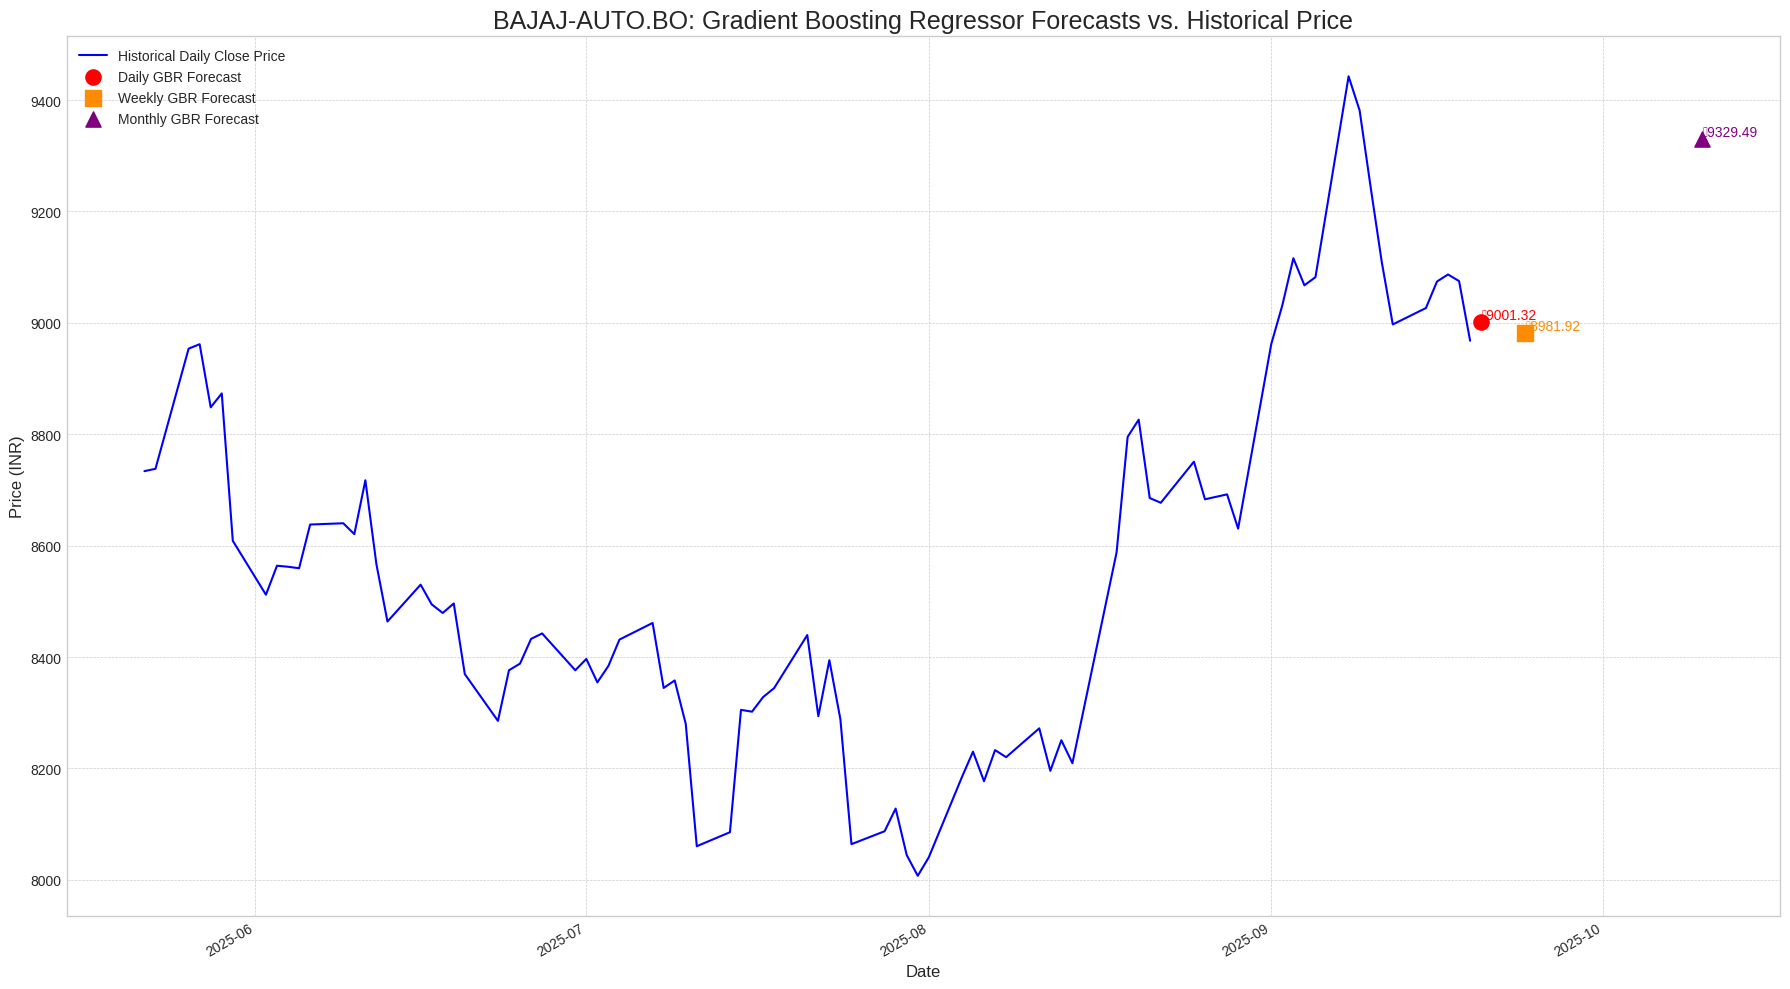


Saving GBR predictions to CSV...

GBR prediction data saved to 'BAJAJ-AUTO.BO_gbr_predictions.csv'

To predict for a different stock, you would need to change the 'TICKER' variable and rerun this cell.


/tmp/ipython-input-3350880334.py:319: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_last_close = float(last_close_gbr) # Ensure it's a float


In [ ]:
import matplotlib.pyplot as plt
from datetime import timedelta
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import pandas as pd
import numpy as np
import yfinance as yf
import os
from datetime import datetime, timezone
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor

# --------------- CONFIG ----------------
TICKER = "BAJAJ-AUTO.BO"
INTERVAL = "1d"
PERIOD = "10y"
WINDOW = 60
HORIZONS = [1, 5, 21]
PAST_RETURNS_LENGTH = 30

# --- File Paths ---
MODEL_FILE = f"model_{TICKER.lower()}_dwm.joblib"
SCALER_FILE = f"scaler_{TICKER.lower()}_dwm.joblib"
LOG_FILE = "logs/predictions_dwm.csv"
os.makedirs("logs", exist_ok=True)
# ---------------------------------------

def fetch_history(ticker: str, interval: str, period: str) -> pd.DataFrame:
    """Fetches and cleans historical market data."""
    print(f"Fetching {period} of {interval} data for {ticker}...")
    try:
        df = yf.download(
            tickers=ticker,
            interval=interval,
            period=period,
            progress=False,
            threads=False,
            auto_adjust=False
        )
        if df is None or df.empty:
            print("No data returned from yfinance.")
            return pd.DataFrame()

        if not isinstance(df.index, pd.DatetimeIndex):
            df.index = pd.to_datetime(df.index)

        cols = ["Open", "High", "Low", "Close", "Volume"]
        df = df.loc[:, cols]
        for c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")
        df.dropna(inplace=True)

        print(f"Successfully fetched {len(df)} rows of data.")
        return df

    except Exception as e:
        print(f"An error occurred during data fetch: {e}")
        return pd.DataFrame()

def build_features_and_targets(df: pd.DataFrame, window: int, horizons: list):
    """
    Builds feature set (X) and multi-horizon targets (y) from daily data.
    """
    print("Building features and targets...")
    X_list, y_list = [], []

    for i in range(window, len(df) - max(horizons)):
        window_slice = df.iloc[i - window : i]
        close_prices = window_slice["Close"]
        volume = window_slice["Volume"]

        past_returns = close_prices.pct_change().dropna().values
        if past_returns.ndim > 1:
            past_returns = past_returns.flatten()

        mean_return = np.mean(past_returns)
        std_return = np.std(past_returns)
        mean_volume = np.mean(volume)

        current_date = df.index[i]
        day_of_week = current_date.dayofweek / 6.0
        month_of_year = current_date.month / 12.0

        padded_past_returns = np.zeros(PAST_RETURNS_LENGTH)
        actual_returns_length = min(len(past_returns), PAST_RETURNS_LENGTH)
        padded_past_returns[-actual_returns_length:] = past_returns[-actual_returns_length:]

        features = np.array([
            mean_return,
            std_return,
            mean_volume,
            day_of_week,
            month_of_year,
            *padded_past_returns
        ])

        current_price = df.iloc[i]["Close"]

        future_returns = []
        for h in horizons:
            if i + h >= len(df):
                future_returns.append(np.nan)
            else:
                future_price = df.iloc[i + h]["Close"]
                future_return = (future_price - current_price) / (current_price + 1e-9)
                future_returns.append(future_return)

        if not any(np.isnan(future_returns)):
             X_list.append(features)
             y_list.append(future_returns)

    X = np.array(X_list)
    y = np.array(y_list)
    y = y.reshape(y.shape[0], -1)
    print(f"Built X, y shapes: {X.shape}, {y.shape}")
    return X, y


def train_and_save(X, y):
    """Trains a model, evaluates it, and saves it to disk."""
    print("Training new model...")
    if X.shape[0] != y.shape[0]:
        raise RuntimeError(f"Shape mismatch: X={X.shape[0]}, y={y.shape[0]}")

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, shuffle=False)

    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_val_s = scaler.transform(X_val)

    base_estimator = GradientBoostingRegressor(n_estimators=150, learning_rate=0.05, max_depth=5, random_state=42)
    model = MultiOutputRegressor(base_estimator, n_jobs=-1)
    model.fit(X_train_s, y_train)

    # Evaluate model
    y_pred = model.predict(X_val_s)
    print("\nModel Performance Evaluation on Validation Set:")
    for i, h in enumerate(HORIZONS):
        mae = mean_absolute_error(y_val[:, i], y_pred[:, i])
        r2 = r2_score(y_val[:, i], y_pred[:, i])
        print(f"  - Horizon {h}-day => Validation MAE: {mae:.6f} | R²: {r2:.4f}")

    joblib.dump(model, MODEL_FILE)
    joblib.dump(scaler, SCALER_FILE)
    print(f"Saved model to {MODEL_FILE} and scaler to {SCALER_FILE}.")
    return model, scaler


def load_model_and_scaler():
    """Loads a pre-trained model and scaler if they exist."""
    if os.path.exists(MODEL_FILE) and os.path.exists(SCALER_FILE):
        print("Loading existing model and scaler from disk.")
        model = joblib.load(MODEL_FILE)
        scaler = joblib.load(SCALER_FILE)
        return model, scaler
    return None, None


def make_prediction_vector(df_recent: pd.DataFrame, window: int):
    """Creates a single feature vector from the most recent data for prediction."""
    if len(df_recent) < window:
        print("Not enough recent data to create a feature vector.")
        return None

    window_slice = df_recent.iloc[-window:]
    close_prices = window_slice["Close"]
    volume = window_slice["Volume"]

    past_returns = close_prices.pct_change().dropna().values
    if past_returns.ndim > 1:
        past_returns = past_returns.flatten()

    mean_return = np.mean(past_returns)
    std_return = np.std(past_returns)
    mean_volume = np.mean(volume)

    current_date = df_recent.index[-1]
    day_of_week = current_date.dayofweek / 6.0
    month_of_year = current_date.month / 12.0

    padded_past_returns = np.zeros(PAST_RETURNS_LENGTH)
    actual_returns_length = min(len(past_returns), PAST_RETURNS_LENGTH)
    padded_past_returns[-actual_returns_length:] = past_returns[-actual_returns_length:]

    features = np.array([
        mean_return,
        std_return,
        mean_volume,
        day_of_week,
        month_of_year,
        *padded_past_returns
    ]).reshape(1, -1)

    return features


def log_prediction(timestamp, ticker, pred_returns, last_price):
    """Logs the predictions to a CSV file."""
    row = {
        "timestamp": timestamp,
        "ticker": ticker,
        "last_price": float(last_price),
    }
    for i, h in enumerate(HORIZONS):
        ret = pred_returns[i]
        row[f"pred_ret_{h}d"] = float(ret)
        row[f"pred_price_{h}d"] = float(last_price * (1 + ret))

    df_log = pd.DataFrame([row])
    header = not os.path.exists(LOG_FILE)
    df_log.to_csv(LOG_FILE, mode="a", header=header, index=False)
    print(f"Prediction logged to {LOG_FILE}")


# Redefine config variables for this cell to be self-contained if not global
TICKER = "BAJAJ-AUTO.BO"
INTERVAL = "1d"
PERIOD = "10y"
WINDOW = 60
HORIZONS = [1, 5, 21]
PAST_RETURNS_LENGTH = 30
MODEL_FILE = f"model_{TICKER.lower()}_dwm.joblib"
SCALER_FILE = f"scaler_{TICKER.lower()}_dwm.joblib"
LOG_FILE = "logs/predictions_dwm.csv"
os.makedirs("logs", exist_ok=True)

# --- 1. Train/Load GBR Model and Get Predictions ---
model, scaler = load_model_and_scaler()
if model is None or scaler is None:
    df_hist_gbr = fetch_history(TICKER, INTERVAL, PERIOD)
    if df_hist_gbr.empty:
        print("Cannot train GBR model without historical data.")
        df_recent_gbr, pred_returns_gbr, last_close_gbr = None, None, None
    else:
        X_gbr, y_gbr = build_features_and_targets(df_hist_gbr, WINDOW, HORIZONS)
        if X_gbr.size == 0:
            print("Failed to build features for GBR.")
            df_recent_gbr, pred_returns_gbr, last_close_gbr = None, None, None
        else:
            model, scaler = train_and_save(X_gbr, y_gbr)
            # Fetch data again to get the most recent for prediction
            df_recent_gbr = fetch_history(TICKER, INTERVAL, period=f"{WINDOW + max(HORIZONS) + 5}d")
            if df_recent_gbr.empty or len(df_recent_gbr) < WINDOW + max(HORIZONS):
                 print("Not enough recent data to make a GBR prediction. Skipping GBR prediction.")
                 df_recent_gbr, pred_returns_gbr, last_close_gbr = None, None, None
            else:
                feature_vector_gbr = make_prediction_vector(df_recent_gbr, WINDOW)
                if feature_vector_gbr is not None:
                    fv_scaled_gbr = scaler.transform(feature_vector_gbr)
                    pred_returns_gbr = model.predict(fv_scaled_gbr)[0]
                    last_close_gbr = df_recent_gbr.iloc[-1]["Close"]
                    # Log GBR prediction
                    now_utc_gbr = datetime.now(timezone.utc).strftime("%Y-%m-%d %H:%M:%S %Z")
                    log_prediction(now_utc_gbr, TICKER, pred_returns_gbr, float(last_close_gbr))
                else:
                    df_recent_gbr, pred_returns_gbr, last_close_gbr = None, None, None
else:
     # Model and scaler loaded successfully
     df_recent_gbr = fetch_history(TICKER, INTERVAL, period=f"{WINDOW + max(HORIZONS) + 5}d")
     if df_recent_gbr.empty or len(df_recent_gbr) < WINDOW + max(HORIZONS):
          print("Not enough recent data to make a GBR prediction. Skipping GBR prediction.")
          df_recent_gbr, pred_returns_gbr, last_close_gbr = None, None, None
     else:
          feature_vector_gbr = make_prediction_vector(df_recent_gbr, WINDOW)
          if feature_vector_gbr is not None:
               fv_scaled_gbr = scaler.transform(feature_vector_gbr)
               pred_returns_gbr = model.predict(fv_scaled_gbr)[0]
               last_close_gbr = df_recent_gbr.iloc[-1]["Close"]
               # Log GBR prediction
               now_utc_gbr = datetime.now(timezone.utc).strftime("%Y-%m-%d %H:%M:%S %Z")
               log_prediction(now_utc_gbr, TICKER, pred_returns_gbr, float(last_close_gbr))
          else:
               df_recent_gbr, pred_returns_gbr, last_close_gbr = None, None, None


# --- 2. Visualize GBR predictions ---
if df_recent_gbr is not None and pred_returns_gbr is not None and last_close_gbr is not None:
    last_date_recent_gbr = df_recent_gbr.index[-1]

    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(18, 10))

    ax.plot(df_recent_gbr.index, df_recent_gbr['Close'], label='Historical Daily Close Price', color='blue', linewidth=1.5)

    colors_gbr = ['red', 'darkorange', 'purple']
    markers_gbr = ['o', 's', '^']
    labels_gbr = ['Daily GBR Forecast', 'Weekly GBR Forecast', 'Monthly GBR Forecast']

    for i, h in enumerate(HORIZONS):
        pred_date_gbr = last_date_recent_gbr + timedelta(days=h)
        pred_price_gbr = float(last_close_gbr) * (1 + pred_returns_gbr[i])

        ax.scatter([pred_date_gbr], [float(pred_price_gbr)], color=colors_gbr[i], marker=markers_gbr[i], s=120, zorder=5, label=labels_gbr[i])
        ax.text(pred_date_gbr, float(pred_price_gbr), f"₹{float(pred_price_gbr):.2f}",
                fontsize=10, verticalalignment='bottom', horizontalalignment='left', color=colors_gbr[i])

    ax.set_title(f'{TICKER}: Gradient Boosting Regressor Forecasts vs. Historical Price', fontsize=18)
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Price (INR)', fontsize=12)
    ax.legend(fontsize=10, loc='upper left')
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    fig.autofmt_xdate()
    plt.tight_layout()
    plt.show()
else:
    print("Skipping GBR visualization due to missing data or failed prediction.")


# --- 3. Analyze Model Performance (already done in train_and_save if model was trained) ---
# The MAE and R2 scores are printed during the train_and_save function call.


# --- 4. Save GBR Predictions to CSV ---
print("\nSaving GBR predictions to CSV...")
if pred_returns_gbr is not None and last_close_gbr is not None:
    comparison_data = []
    current_last_close = float(last_close_gbr) # Ensure it's a float

    for i, h in enumerate(HORIZONS):
        gbr_pred_price = current_last_close * (1 + pred_returns_gbr[i])
        comparison_data.append({
            'Horizon': f'{h}-day',
            'Last Close Price': current_last_close,
            'GBR Predicted Price': gbr_pred_price
        })

    ticker_symbol = TICKER # Define ticker_symbol in this cell
    comparison_df = pd.DataFrame(comparison_data)
    output_filename = f'{ticker_symbol}_gbr_predictions.csv'
    comparison_df.to_csv(output_filename, index=False)
    print(f"\nGBR prediction data saved to '{output_filename}'")
else:
    print("Skipping saving GBR predictions due to missing data.")

# --- 5. Predict for a Different Stock ---
# This step requires user input for a new ticker symbol and rerunning the prediction logic.
# It cannot be fully automated in a single cell without prompting the user.
# A separate cell or function call with a new ticker would be needed.
print("\nTo predict for a different stock, you would need to change the 'TICKER' variable and rerun this cell.")